# <center>Machine learning from scratch - Day 1, Part II</center>
## <center>17 July, 2019 @ Bayer AG R&D, Berlin, Germany</center>
### <center>Marco Chierici & Margherita Francescatto</center>
#### <center>_FBK/MPBA_</center>

In this handout we will go through basic concepts of machine learning using Python and scikit-learn, first on the classic Iris dataset, then on a real-world dataset of biological relevance [Zhang et al, _Genome Biology_, 2015].

# Neuroblastoma dataset

In this section, we will focus on the SEQC Neuroblastoma dataset, specifically on **a subset of 272 samples (136 training, 136 test)**, aiming at predicting an **extreme disease outcome** (favorable vs unfavorable samples: see [main paper](https://www.ncbi.nlm.nih.gov/pubmed/26109056)).

<img src="zhang.png" width="65%" />

<img src="zhang_tab2.png" width="95%" />

The data was preprocessed a bit to facilitate the progress of the tutorial.

Let's start by loading a few modules that we'll be using later:

In [1]:
import numpy as np
import pylab as plt ## for plotting
import pandas as pd ## for reading text files and manipulating data frames
from sklearn import neighbors ## kNN classifier
np.random.seed(42) ## set random seed just in case

Define files to read:

In [6]:
##  for convenience, define the data directory as a variable
DATA_DIR = "data/"

In [7]:
DATA_TR = DATA_DIR + "MAV-G_272_tr.txt"
DATA_TS = DATA_DIR + "MAV-G_272_ts.txt"
LABS_TR = DATA_DIR + "labels_tr.txt"
LABS_TS = DATA_DIR + "labels_ts.txt"

_Note:_ from now on we will use the "tr" suffix to denote the training set, and "ts" for the test set.

Read the files in as _pandas dataframes_ (they are conceptually like R data frames):

In [4]:
data_tr = pd.read_csv(DATA_TR, sep="\t")
data_ts = pd.read_csv(DATA_TS, sep="\t")

The function `read_csv` has a lot more input arguments to deal with different situations.

If you want to know more about this or any other Python function, use the `help(function_name)` command or `function_name?`.

Give a look at what we have here, start with getting the dimensions of what we just uploaded:

In [8]:
data_tr.shape

(136, 52230)

What's inside?

A peek at the first rows reveals that the first column (the dataframe index) contains the sample IDs, and the remaining columns are genes:

In [9]:
data_tr.head()

,sampleID,ALB.Gene_AceView,CD24L4.1.Gene_AceView,RPS11.Gene_RefSeq,RPS18.Gene_AceView,C5orf13.Gene_AceView,CCT2.Gene_AceView,COL1A1.Gene_AceView,DDX1.Gene_AceView,EEF1A1.Gene_AceView,...,zawskaw.Gene_AceView,zeedor.Gene_AceView,zergor.Gene_AceView,zorsa.Gene_AceView,zoychabu.Gene_AceView,zoysteeby.Gene_AceView,zudee.Gene_AceView,zureyby.Gene_AceView,zuswoybu.Gene_AceView,zyjee.Gene_AceView
0,SEQC_NB001,9.29,18.82,21.17,20.90,20.02,16.31,18.60,15.73,21.71,...,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0
1,SEQC_NB003,9.25,20.25,22.44,22.00,21.05,17.06,19.39,22.84,22.72,...,0.0,5.54,0.0,3.39,0.0,0.0,5.45,0.0,0.0,0.0
2,SEQC_NB005,8.99,20.09,22.09,21.71,21.65,16.85,23.02,15.79,22.24,...,0.0,0.00,0.0,3.75,0.0,0.0,0.00,0.0,0.0,0.0
3,SEQC_NB011,7.32,19.82,20.52,20.90,21.58,16.49,18.91,15.45,22.06,...,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0
4,SEQC_NB013,10.56,21.19,20.69,21.29,20.28,16.22,17.15,16.01,21.84,...,0.0,0.00,0.0,5.20,0.0,0.0,0.00,0.0,0.0,0.0


Drop the first column from the train and test expression sets, since it's just the sample IDs (we put them in to be able to check whether samples and labels match, but once we are sure of what we are doing we don't really need them anymore).

In [10]:
data_tr = data_tr.drop('sampleID', axis=1)
data_ts = data_ts.drop('sampleID', axis=1)

Check what happened

In [11]:
data_tr.head()

,ALB.Gene_AceView,CD24L4.1.Gene_AceView,RPS11.Gene_RefSeq,RPS18.Gene_AceView,C5orf13.Gene_AceView,CCT2.Gene_AceView,COL1A1.Gene_AceView,DDX1.Gene_AceView,EEF1A1.Gene_AceView,FLT3LG_.Gene_AceView,...,zawskaw.Gene_AceView,zeedor.Gene_AceView,zergor.Gene_AceView,zorsa.Gene_AceView,zoychabu.Gene_AceView,zoysteeby.Gene_AceView,zudee.Gene_AceView,zureyby.Gene_AceView,zuswoybu.Gene_AceView,zyjee.Gene_AceView
0,9.29,18.82,21.17,20.90,20.02,16.31,18.60,15.73,21.71,20.02,...,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0
1,9.25,20.25,22.44,22.00,21.05,17.06,19.39,22.84,22.72,21.26,...,0.0,5.54,0.0,3.39,0.0,0.0,5.45,0.0,0.0,0.0
2,8.99,20.09,22.09,21.71,21.65,16.85,23.02,15.79,22.24,20.75,...,0.0,0.00,0.0,3.75,0.0,0.0,0.00,0.0,0.0,0.0
3,7.32,19.82,20.52,20.90,21.58,16.49,18.91,15.45,22.06,19.59,...,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0
4,10.56,21.19,20.69,21.29,20.28,16.22,17.15,16.01,21.84,19.74,...,0.0,0.00,0.0,5.20,0.0,0.0,0.00,0.0,0.0,0.0


Read in the files containing label information and check how they look like.

In [13]:
labs_tr = pd.read_csv(LABS_TR, sep = "\t")
labs_ts = pd.read_csv(LABS_TS, sep = "\t")
labs_tr.head()

,sampleID,CLASS,SEX,RND
0,SEQC_NB001,0,1,1
1,SEQC_NB003,0,0,0
2,SEQC_NB005,0,0,1
3,SEQC_NB011,1,1,1
4,SEQC_NB013,0,1,1


We have to fit one model for each label type, so we need to select one column at a time. We start with CLASS, in principle we could consider looping over the columns of interest. In this case no need to remove the first column, since we are using one column at a time.

In [14]:
class_lab_tr = labs_tr[['CLASS']]
class_lab_ts = labs_ts[['CLASS']]
## give a look at one of the two
class_lab_tr.head()

,CLASS
0,0
1,0
2,0
3,1
4,0


For the remaining part of this hands-on, we need the data and labels to be stored in Numpy arrays (remember the `.values` function?):

In [15]:
x_tr = data_tr.values
x_ts = data_ts.values

y_tr = class_lab_tr.values.ravel()
y_ts = class_lab_ts.values.ravel()

In [16]:
y_tr

array([0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1])

In [17]:
y_tr.shape

(136,)



---


*Naming conventions: in the machine learning world, usually `x` is the data and `y` the target variable (the labels). *

---



When coding, it is a good practice to have a peek at the resulting variables, to be sure everything is OK: i.e., is that variable like it is supposed to be? Did I accidentally throw away a feature column?

This can avoid lots of problems later on!

In [20]:
x_tr.shape

(136, 52229)

Let's go back to the sample labels:

In [21]:
y_tr.shape

(136,)

---

### Quick recap

- class_lab_tr = 0 indicates **unfavorable** neuroblastoma samples (**bad** outcome)
- class_lab_tr = 1 indicates **favorable** neuroblastoma samples (**good** outcome)

---

# Data preprocessing

The downstream analysis can benefit from data preprocessing, i.e., rescaling or standardizing data values.

In Scikit learn you can use `MinMaxScaler` or `StandardScaler` in the `preprocessing` submodule. Here is an example using the `MinMaxScaler`:

In [22]:
from sklearn.preprocessing import MinMaxScaler
## first you need to create a "scaler" object
scaler = MinMaxScaler(feature_range=(-1,1))
## then you actually scale data by fitting the scaler object on the data
scaler.fit(x_tr)
x_tr = scaler.transform(x_tr)
x_ts = scaler.transform(x_ts)

Note how we transformed the test set: we computed the scaling parameters on the training set and applied them to the test set. In this way, we did not use any information in the test set to standardize it.

# Data exploration

Remember the scatterplot matrix we showed on the 4-feature Iris data?

_How should we visualize feature relationships on the neuroblastoma dataset with 50K features? Would it be a good idea to compute a scatterplot matrix?_

It is probably better to first reduce the dimensionality of our data.

Principal Component Analysis (PCA) is one example of data dimesionality reduction technique. It finds a sequence of linear combination of the variables (called the _principal components_) that explain the maximum variance and summarize the most information in the data and are mutually uncorrelated.

Let's perform an **unsupervised learning** task on our data set "as is" by decomposing it in its Principal Components.

In scikit-learn, we can use the module PCA:

In [23]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

So far we have a PCA _object_ but no transformation yet.

To actually transform the data, we'll have to _fit_ the PCA object on the training data, and then _transforming_ them in the Principal Component space:

In [24]:
pca.fit(x_tr)
z_tr = pca.transform(x_tr)

In [25]:
z_tr.shape

(136, 2)

In [26]:
x_tr.shape

(136, 52229)

Let's have a look at the _variance ratio_, i.e. the percentage of the variance explained by each component:

In [27]:
print(pca.explained_variance_ratio_)

[0.08194369 0.0433671 ]


_What can you understand from these variance percentages? Could this task be "predictable" by some sort of model?_

Is it always convenient to visualize the first two principal components in a scatterplot, in order to get a first assessment of the goodness of the decomposition.

We will color the points in the plot according to our sample labels.

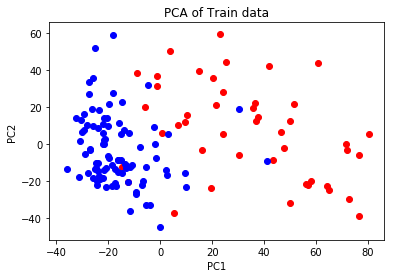

In [28]:
f = plt.figure()
plt.scatter(z_tr[y_tr == 0, 0], z_tr[y_tr == 0, 1], color="r")
plt.scatter(z_tr[y_tr == 1, 0], z_tr[y_tr == 1, 1], color="b")
plt.title("PCA of Train data")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
f.savefig("PCA_train.pdf")

_Now apply the transformation to the test data, plot it, and save it as PDF._

In [ ]:
## exercise here

## Supervised Learning

### k-NN classifier

Based on the PCA we built on our data, we decide to try some supervised learning on them.

Scikit-learn provides you access to several models via a very convenient _fit_ and _predict_ interface.

For example, let's fit a **k-NN** model on the whole training data and then use it to predict the labels of the test data.

In [29]:
knn = neighbors.KNeighborsClassifier(n_neighbors=10)

In [30]:
knn.fit(x_tr, y_tr)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [31]:
y_pred_knn = knn.predict(x_ts) # predict labels on test data

_In general, a classifier has **parameters** that need to be tuned. Default choices are not good in all situations._

_For example, in k-NN the main parameter is the **number of neighbors** used in the nearest neighbors algorithm._

_More on this in the next lecture!_

To evaluate the predictions we need some kind of metrics. 

_Exercise: extract confusion matrix and try calculate metrics by hand._

### Recap: confusion matrix

In this example, the first row is class 0, so the confusion matrix will look like:

|      |  |  Predicted  |    |
|------|-----------|----|----|
|      |           | 0 | 1  |
| True | 0        | TN | FP |
|      | 1         | FN | TP |


In [ ]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_ts, y_pred_knn)
conf

The total number of class 0 test samples (AN = All Negatives) should be equal to the sum of the first row of the confusion matrix, i.e., TN + FP:

In [ ]:
np.sum(y_ts==0) # total number of "class 0" samples in the test set

Similarly for class 1, i.e., AP = All Positives = TP + FN:

In [ ]:
np.sum(y_ts==1) # total number of "class 1" samples in the test set

Compute the Accuracy, remembering/using the formula: 

ACC = (TN + TP) / (TN + TP + FN + FP)

In [ ]:
tp = conf[1,1]
tn = conf[0,0]
fp = conf[0,1]
fn = conf[1,0]

acc = (tn + tp) / (tn + tp + fn + fp)
print(acc)

Now compute the Sensitivity.

Remember the formula:

SENS = TP / (TP + FN)

In [ ]:
tp / (tp + fn)

Computing metrics by hand is good, but what about a quicker option?

As seen in the lectures, Scikit Learn offers a handy broad range of functions to evaluate your classifier through its submodule `metrics`.

Let's compute the accuracy using the scikit-learn built-in function `accuracy_score`, taking as input the predicted labels (`y_pred_knn`) and the true labels (`y_ts`):

`accuracy_score(y_pred_knn, y_ts)`

In [ ]:
from sklearn import metrics
metrics.accuracy_score(y_ts, y_pred_knn)

What about Sensitivity? The built-in function is called `recall_score`, as Recall is an alternate name for Sensitivity. Again, its input are the predicted and the true labels.


In [ ]:
metrics.recall_score(y_ts, y_pred_knn)

Scikit-learn also provides a neat `metrics.classification_report` function that outputs a few metrics stratified by class:

In [ ]:
print(metrics.classification_report(y_ts, y_pred_knn))

Let's consider the Matthews Correlation Coefficient (MCC):

![MCC formula](https://www.researchgate.net/profile/Pablo_Moscato/publication/223966631/figure/fig1/AS:305103086080001@1449753652505/Calculation-of-Matthews-Correlation-Coefficient-MCC-A-Contingency-matrix_W640.jpg)

*Q: Do you remember the main features of MCC?*

In scikit-learn it is computed by the `metrics.matthews_corrcoef` function.

If we get the MCC for our kNN predictions, we can observe that it is in line with our *a priori* knowledge of the dataset (from the article):

In [ ]:
print(metrics.matthews_corrcoef(y_ts, y_pred_knn))

*Compare the metrics that you computed so far. What can you say about this classification task? Does the classifier learn something?*

The metrics may look good (e.g., accuracy around 0.8, MCC above 0.6) but...

... how do you know if this model performs similarly well on unseen data?

In other words, does this model *generalize* beyond its training set?

This is why *data partitioning* techniques are used.

## Data partitioning

### Hold-out strategy

The idea behind data partitioning is to split your original data set into a **train** portion (for developing your machine learning model) and a **test** portion (for evaluating the performance of the trained model).

The simplest and most straightforward way to partition your data set is to randomly split it in two groups (*hold-out strategy*).


---


"But we already have a dataset split into train and test!", you may object.

Well, the data was previously split into balanced train and test sets of 136 samples each. This is somewhat different from the 80/20 train/test split we mentioned in the lecture. In fact, this specific data split was created ad-hoc during the article preparation to ensure balance in the various clinical characteristics of the neuroblastoma samples represented (e.g. MYCN amplification status, INSS tumor staging, … Full details are reported in the article).

For the sake of this tutorial, we will further split the neuroblastoma train set into two subsets.


---


You achieve this using scikit-learn's function `train_test_split`, in the `model_selection` submodule.

For example, let's split the data (x_tr) into 80% train and 20% test (note the argument `test_size=0.2`)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_tr, y_tr, test_size=0.2, random_state=1)



---

What is the random_state?

Whenever randomness is involved in a computer program, we need to rely on some sort of workaround because computers follow their instructions blindly and they are therefore completely predictable.

One approach relies on *Pseudo-Random Number Generators* (PRNGs). 

PNRGs are algorithms that use mathematical formulas or precalculated tables to produce sequences of numbers that appear random. 

PNRGs are initialized by a *seed* (an integer), so that *the same seed yields the same sequence of pseudo-random numbers*. This is useful for reproduciblity.


---



*Now, retrain a kNN model on X_train and evaluate its performance on X_test. Try using different random states for data splitting.*

In [ ]:
from sklearn import metrics
knn = neighbors.KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

acc = metrics.accuracy_score(y_test, y_pred_knn)
mcc = metrics.matthews_corrcoef(y_test, y_pred_knn)

print("Accuracy = " , acc)
print("MCC = ", mcc)